<a href="https://www.kaggle.com/code/valentindefour/titanic-few-useful-functions-and-a-simple-model?scriptVersionId=94066331" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn import feature_selection
from sklearn import model_selection

from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sb

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# DECLARING FEW FUNCTIONS

prepare_data performs data loading and preparation : changing text values to categorical, handling missing values, ...

Note : the data pred I did is based on previous EDA I did and didn't explain here as you can find plenty of them (thumbs up for the "[data science framework](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy#Step-5:-Model-Data)" from [LD Freeman](https://www.kaggle.com/ldfreeman3)) :

In [2]:
def prepare_data():
    
    train = pd.read_csv('/kaggle/input/titanic/train.csv')
    test = pd.read_csv('/kaggle/input/titanic/test.csv')
    
    def format_df(df):
        
        df = df.join(pd.get_dummies(df['Sex'], prefix='is', drop_first = True))

        df = df.join(pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first = True))

        df['title_norm'] = df['Name'].map(lambda x: 'Mr.' if 'Mr.' in x
                                          else 'Mrs.' if 'Mrs.' in x
                                          else 'Miss' if 'Miss' in x
                                          else 'Master' if 'Master' in x
                                          else 'None')

        df = df.join(pd.get_dummies(df['title_norm'], prefix = 'is', drop_first = True))

        df['Age'].fillna(df['Age'].mean(), inplace = True)

        df['Fare_log'] = df['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

        df['size_fam'] = df['SibSp'] + df['Parch']

        df['is_alone'] = df['size_fam'].map(lambda x: 1 if x>0 else 0)

        df['is_child'] = df['Age'].map(lambda x: 1 if x<8 else 0)

        df.drop(['Cabin','Ticket','Name','Sex','Embarked','title_norm','Fare'], axis = 1, inplace = True)

        df.set_index('PassengerId', inplace = True, drop = True)
        
        return df
    
    train = format_df(train)
    test = format_df(test)
    
    features = test.columns
    target = train['Survived']
    
    return train, test, features, target

compare_classifiers takes a list of common classifiers and test them on our training dataset to see, on a first approach, which one tends to perform better. You can easily add classifiers to the list to increase the number of comparisons :

In [3]:
def compare_classifiers():
    
    classifiers = [ensemble.GradientBoostingClassifier(),ensemble.RandomForestClassifier(),naive_bayes.GaussianNB(),neighbors.KNeighborsClassifier(),
                   svm.SVC(probability=True),tree.DecisionTreeClassifier(),XGBClassifier(),linear_model.LogisticRegression(max_iter = 500)]
    
    classifiers_comparison = pd.DataFrame()

    cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .4, train_size = .6, random_state = 42 )

    for classifier in classifiers:
        
        classifier.fit(X_train, Y_train)
        classifiers_comparison = classifiers_comparison.append({'classifier':classifier.__class__.__name__,
                                    'score_train': classifier.score(X_train, Y_train),
                                    'fit_time': model_selection.cross_validate(classifier, train[features], target, cv  = cv_split)['fit_time'].mean(),
                                    'score_time': model_selection.cross_validate(classifier, train[features], target, cv  = cv_split)['score_time'].mean(),
                                    'score_test': model_selection.cross_validate(classifier, train[features], target, cv  = cv_split)['test_score'].mean()},
                                   ignore_index = True)
    
    return classifiers, classifiers_comparison.sort_values(by='score_test', ascending = False)

features_viz allows to visualize features importance for a given model :

In [4]:
def features_viz(clf):
    
    plt.figure(figsize=(20,7))
    
    clf.fit(X_train, Y_train)
    print(clf.__class__.__name__)
    print(clf.get_params())
    df = pd.DataFrame({'features':features, 'importance':clf.feature_importances_})
    df.sort_values(by = 'importance', ascending = False, inplace = True)

    sb.barplot(df.features, df.importance)

test_viz_params allows to pass a classifier and a parameters grid to perform multiple GridSearch and print the resulting test_score as lineplots :

In [5]:
def test_viz_params(clf, params, num_of_cv):
    
    n=1
    plt.figure(figsize=(20,20))
    
    for parameter in params:
        
        test_results = []
                    
        model = model_selection.GridSearchCV(estimator = clf,
                                             param_grid = {parameter : params[parameter]},
                                             cv = num_of_cv,
                                             n_jobs = -1,
                                             verbose = False,
                                             scoring = 'accuracy')
        
        model.fit(X_train, Y_train)
        
        print(model.best_params_)

        test_results = model.cv_results_['mean_test_score'].tolist()
                
        plt.subplot(int(len(params)/2)+1,2,n)
        sb.lineplot(params[parameter], test_results)
        plt.ylabel("Accuracy")
        plt.xlabel(parameter)
        
        n+=1

# DEMONSTRATING ALL FUNCTIONS

In [6]:
train, test, features, target = prepare_data()

X_train, X_test, Y_train, Y_test = train_test_split(train[features], target, random_state=42)

In [7]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,is_male,Embarked_Q,Embarked_S,is_Miss,is_Mr.,is_Mrs.,is_None,Fare_log,size_fam,is_alone,is_child
PassengerId,,,,,,,,,,,,,,,,
1,0,3,22.0,1,0,1,0,1,0,1,0,0,1.981001,1,1,0
2,1,1,38.0,1,0,0,0,0,0,0,1,0,4.266662,1,1,0
3,1,3,26.0,0,0,0,0,1,1,0,0,0,2.070022,0,0,0
4,1,1,35.0,1,0,0,0,1,0,0,1,0,3.972177,1,1,0
5,0,3,35.0,0,0,1,0,1,0,1,0,0,2.085672,0,0,0


In [8]:
classifiers_list, classifiers_dataframe = compare_classifiers()

classifiers_dataframe

,classifier,fit_time,score_test,score_time,score_train
0,GradientBoostingClassifier,0.101823,0.828571,0.003034,0.917665
7,LogisticRegression,0.072992,0.814566,0.002138,0.839820
1,RandomForestClassifier,0.168396,0.807843,0.014477,0.983533
6,XGBClassifier,0.046721,0.805602,0.004001,0.970060
2,GaussianNB,0.003359,0.797199,0.002034,0.802395
3,KNeighborsClassifier,0.003609,0.779272,0.015308,0.839820
5,DecisionTreeClassifier,0.004029,0.769748,0.001858,0.983533
4,SVC,0.067339,0.660504,0.008180,0.688623


GradientBoostingClassifier
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


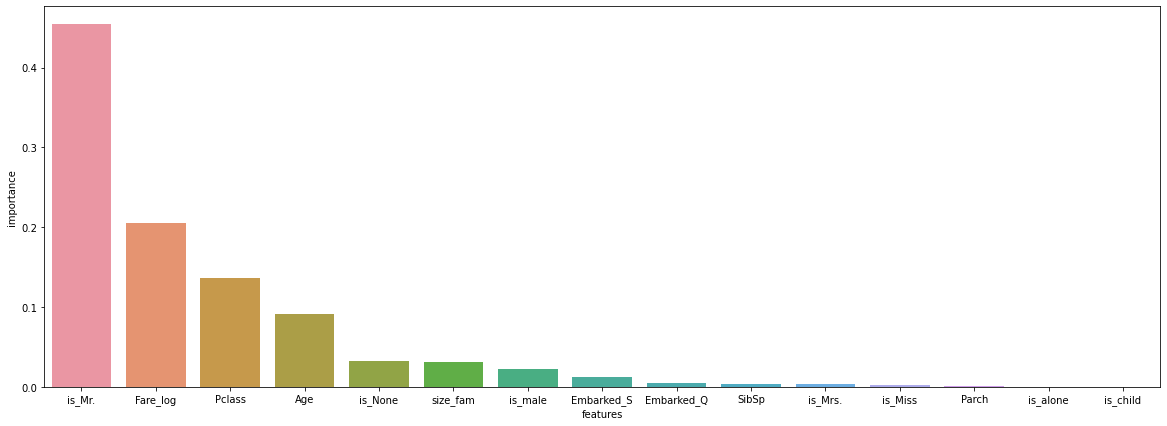

In [9]:
features_viz(classifiers_list[0])

DecisionTreeClassifier
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


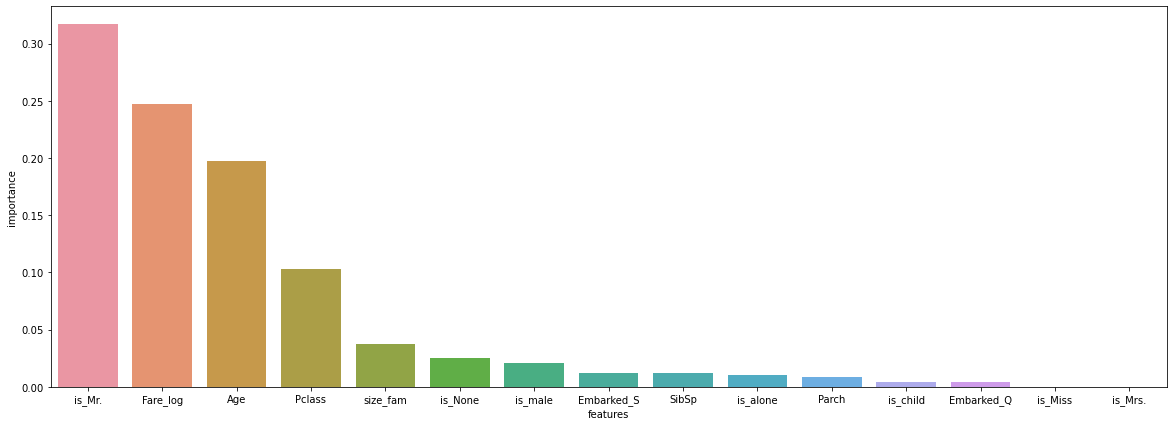

In [10]:
features_viz(classifiers_list[5])

{'max_depth': 4}
{'criterion': 'gini'}
{'min_samples_leaf': 7}
{'min_samples_split': 14}


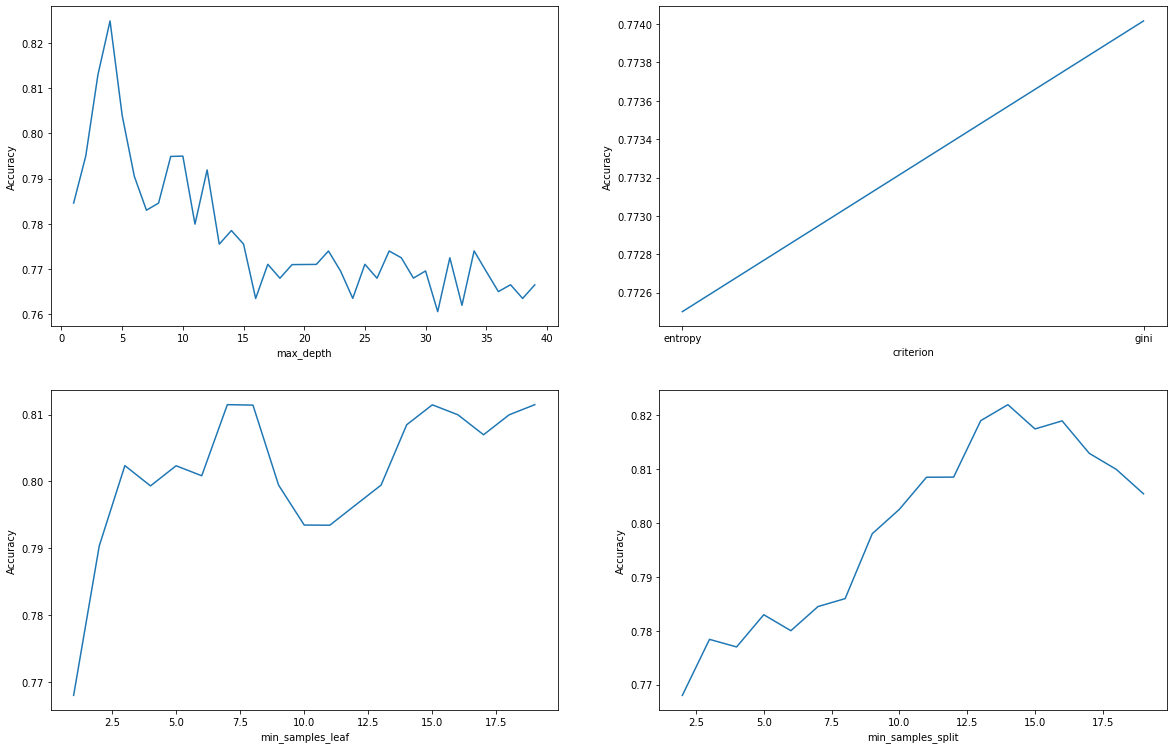

In [11]:
params ={'max_depth' : range(1,40),
         'criterion' : ['gini','entropy'],
             'min_samples_leaf' : range(1,20),
             'min_samples_split' : range(1,20)}

test_viz_params(tree.DecisionTreeClassifier(), params, 10)

# A QUICK SUBMISSION

In [12]:
clf = tree.DecisionTreeClassifier()

params ={'max_depth' : range(1,30),
         'criterion' : ['gini','entropy'],
             'min_samples_leaf' : range(1,10),
             'min_samples_split' : range(1,10)}

GS_clf = model_selection.GridSearchCV(estimator = clf,
                                             param_grid = params,
                                             cv = 5,
                                             n_jobs = -1,
                                             verbose = True,
                                             scoring = 'accuracy')
        
GS_clf.fit(X_train, Y_train)

Fitting 5 folds for each of 4698 candidates, totalling 23490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 13112 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 23444 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 23490 out of 23490 | elapsed:  1.0min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(1, 10)},
             scoring='accuracy', verbose=True)

In [13]:
print(GS_clf.best_params_,GS_clf.best_score_)
print(GS_clf.best_estimator_)

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4} 0.8218606217035125
DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=4)


In [14]:
test['Survived'] = GS_clf.best_estimator_.predict(test)

In [15]:
test['Survived'].to_csv("submission_VD.csv", index = True)

Feel free to comment with questions, improvements ideas or anything related to this short notebook :)